# **Maestría en Inteligencia Artificial Aplicada**
# **Universidad ICESI**


# **Proyecto II de Innovación Tecnológica para Inteligencia Artificial**

**Docente: José Andrés Moncada Q**

**Asesor: Milton Sarria P**

**Estudiantes:**

**Juan M Hurtado A**

**Manuel A Gonzàlez G**

# Sistema de detección temprana de enfermedades en hojas de caña de azúcar usando anàlisis de imàgenes e inteligencia artificial

En este notebook desarrolla un **sistema de detección temprana de enfermedades** en hojas de caña de azúcar, a partir de imágenes, empleando modelos de *deep learning*.

Se utilizan cinco clases de imágenes:

- **Healthy**: hoja sana  
- **Mosaic**: enfermedad tipo mosaico  
- **RedRot**: podredumbre roja  
- **Rust**: roya  
- **Yellow**: amarillamiento (estrés o enfermedad asociada)

Se entrenan y comparan cinco modelos de *deep learning*:

1. CNN simple (baseline)
2. MobileNetV2 (transfer learning)
3. ResNet50 (transfer learning)
4. EfficientNetB0 (transfer learning)
5. DenseNet121 (transfer learning)

El objetivo es **seleccionar el modelo con mejor capacidad diagnóstica** para ser usado como base de un sistema de monitoreo temprano del cultivo.


PASO 1 – **Librerías y configuración**

## 1. Importar librerías y configurar el entorno

En este paso:

- Importamos todas las librerías necesarias para:
  - Manejo de archivos (`os`, `zipfile`).
  - Operaciones numéricas (`numpy`).
  - Visualización (`matplotlib`).
  - Deep learning con TensorFlow/Keras.
  - Métricas de evaluación (`classification_report`, `confusion_matrix`).
- Configuramos una semilla aleatoria para tener resultados reproducibles.
- Verificamos si hay una GPU disponible (útil cuando se ejecuta en Google Colab).


In [ ]:
# ============================================
# 1. Importar librerías y configuración básica
# ============================================

# Manejo de archivos y rutas
import os
import zipfile
import random

# Cálculo numérico y manejo de matrices
import numpy as np

# Visualización de gráficos y figuras
import matplotlib.pyplot as plt

# Utilidad para iterar sobre pares de índices (para la matriz de confusión)
import itertools

# Manejo de tablas para resumen de métricas
import pandas as pd

# Librerías de deep learning con TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modelos preentrenados para Transfer Learning
from tensorflow.keras.applications import (
    MobileNetV2,
    ResNet50,
    EfficientNetB0,
    DenseNet121
)

# Funciones de preprocesamiento específicas para cada modelo preentrenado
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_effnet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet

# Métricas de evaluación de clasificación
from sklearn.metrics import classification_report, confusion_matrix

# Para abrir y verificar integridad de imágenes
from PIL import Image

# Para exportar el modelo a formato ONNX (opcional para despliegue)
try:
    import tf2onnx
except ImportError:
    # Si no está instalado, mostramos un mensaje pero el resto del notebook sigue funcionando
    print("tf2onnx no está instalado. Si lo necesitas, instala con: pip install tf2onnx")

# Definimos una semilla aleatoria para que los resultados sean reproducibles
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Verificamos qué dispositivos físicos (CPU/GPU) están disponibles
print("Dispositivos físicos disponibles:", tf.config.list_physical_devices())



tf2onnx no está instalado. Si lo necesitas, instala con: pip install tf2onnx
Dispositivos físicos disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


PASO 2  **Cargar y extraer el ZIP**

## 2. Cargar y extraer el archivo ZIP con las imágenes

En este paso:

- Indicamos la ruta del archivo `archive.zip` que contiene el dataset de imágenes.
- Creamos una carpeta de destino donde se extraerán las imágenes.
- Extraemos el contenido del ZIP.
- Mostramos las carpetas de primer nivel, que corresponden a las clases (Healthy, Mosaic, RedRot, Rust, Yellow).


In [ ]:
# ============================================
# 2. Cargar y extraer el archivo ZIP del dataset
# ============================================

# Ruta al archivo ZIP. Si estás en Google Colab, primero debes subir el archivo
zip_path = "archive.zip"          # Nombre del archivo ZIP en el entorno de ejecución

# Carpeta donde se extraerá el contenido del ZIP
extract_path = "data_sugarcane"

# Creamos la carpeta de destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Abrimos el archivo ZIP en modo lectura y extraemos todo su contenido
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

# Directorio base donde ahora están las carpetas de cada clase
base_dir = extract_path

print("Directorio base del dataset:", base_dir)
print("Clases (carpetas) encontradas:", os.listdir(base_dir))



Directorio base del dataset: data_sugarcane
Clases (carpetas) encontradas: ['Yellow', 'Mosaic', 'RedRot', 'Healthy', 'Rust']


**Distribución de imágenes por clase**

In [ ]:
import zipfile
from pathlib import Path

zip_path = "/content/archive.zip"   # nombre del zip
extract_path = "/content/sugarcane-leaves"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

base_dir = Path(extract_path)

import pandas as pd

img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
classes = ["Healthy", "Mosaic", "RedRot", "Rust", "Yellow"]

rows = []
for c in classes:
    n = sum(
        1 for f in (base_dir / c).rglob("*")
        if f.is_file() and f.suffix.lower() in img_exts
    )
    rows.append([c, n])

df = pd.DataFrame(rows, columns=["Clase", "Número de imágenes"])
df.loc[len(df)] = ["Total", int(df["Número de imágenes"].sum())]

df

,Clase,Número de imágenes
0,Healthy,522
1,Mosaic,462
2,RedRot,518
3,Rust,514
4,Yellow,505
5,Total,2521


PASO 3  **Limpieza de imágenes corruptas**

## 3. Limpieza: detección y eliminación de imágenes corruptas

En este paso:

- Recorremos todas las carpetas de clases.
- Intentamos abrir cada imagen con `PIL.Image`.
- Si una imagen está corrupta o no se puede abrir, la eliminamos.
- Esto ayuda a evitar errores durante el entrenamiento.


In [ ]:
# ============================================
# 3. Limpieza: detección y eliminación de imágenes corruptas
# ============================================

def remove_corrupted_images(root_dir):
    """
    Recorre todas las subcarpetas de root_dir
    e intenta abrir cada imagen. Si alguna imagen está corrupta
    o no se puede abrir, se elimina del disco.

    Parámetros:
    -----------
    root_dir : str
        Ruta a la carpeta raíz que contiene las subcarpetas por clase.
    """
    removed = 0  # Contador de imágenes eliminadas

    # Recorremos cada carpeta de clase
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)

        # Si no es una carpeta (por ejemplo, un archivo suelto), la saltamos
        if not os.path.isdir(class_path):
            continue

        # Recorremos cada archivo dentro de la carpeta de la clase
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            try:
                # Intentamos abrir la imagen
                with Image.open(fpath) as img:
                    img.verify()  # Verifica que el archivo es una imagen válida
            except Exception:
                # Si se lanza una excepción, consideramos que la imagen está corrupta
                print("Imagen corrupta/eliminada:", fpath)
                os.remove(fpath)
                removed += 1

    print(f"Total de imágenes eliminadas por estar corruptas: {removed}")

# Llamamos a la función de limpieza sobre el directorio base
remove_corrupted_images(base_dir)

Total de imágenes eliminadas por estar corruptas: 0


PASO 4  **Exploración visual rápida**

## 4. Exploración visual del dataset

En este paso:

- Definimos una función que muestra algunas imágenes de ejemplo por cada clase.
- Esto permite revisar visualmente:
  - Calidad de las imágenes.
  - Variabilidad dentro de cada clase.
  - Que el etiquetado sea coherente.


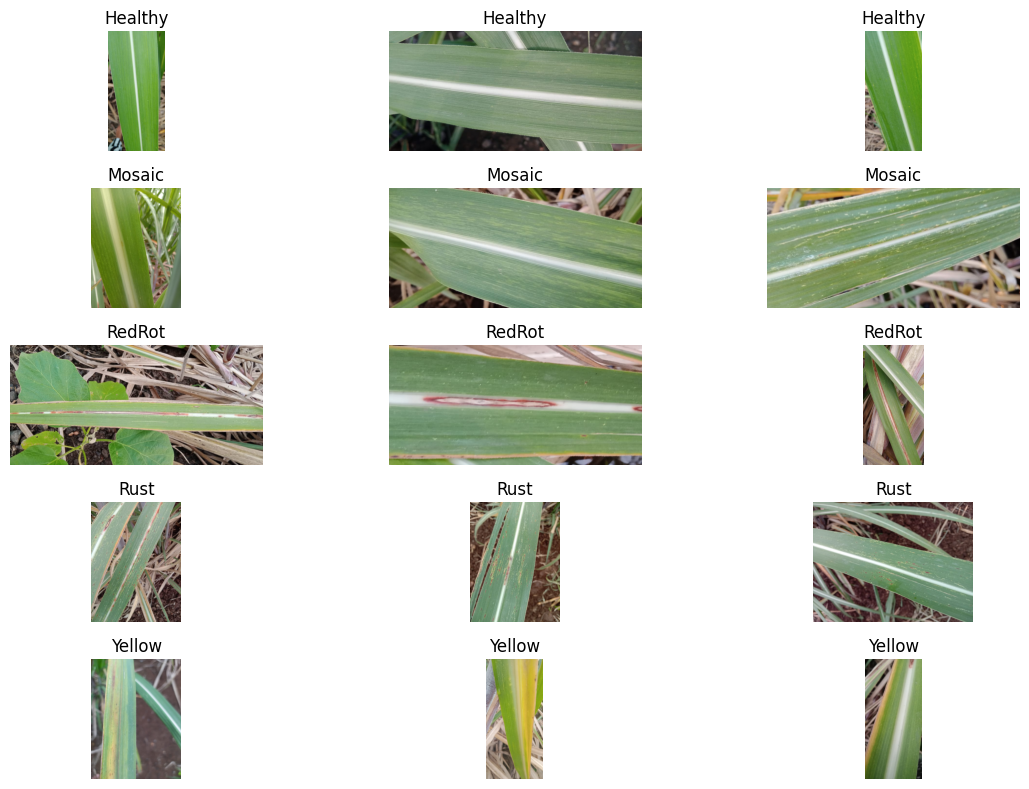

In [ ]:
# ============================================
# 4. Exploración rápida: mostrar ejemplos por clase
# ============================================

# Lista de clases que esperamos encontrar
classes = ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

def show_sample_images(root_dir, classes, n_per_class=3):
    """
    Muestra algunas imágenes de ejemplo para cada clase.

    Parámetros:
    -----------
    root_dir : str
        Carpeta raíz que contiene las subcarpetas por clase.
    classes : list
        Lista con los nombres de las clases (subcarpetas).
    n_per_class : int
        Número de imágenes a mostrar por clase.
    """
    plt.figure(figsize=(12, 8))
    i = 1  # Índice para la posición de subplot

    for cls in classes:
        class_path = os.path.join(root_dir, cls)
        images = os.listdir(class_path)

        # Si no hay imágenes en la clase, la saltamos para evitar errores
        if len(images) == 0:
            continue

        # Seleccionamos aleatoriamente n_per_class imágenes de esta clase
        samples = random.sample(images, min(n_per_class, len(images)))

        for img_name in samples:
            img_path = os.path.join(class_path, img_name)

            # Abrimos la imagen
            img = Image.open(img_path)

            # Creamos un subplot para mostrarla
            plt.subplot(len(classes), n_per_class, i)
            plt.imshow(img)
            plt.axis("off")
            plt.title(cls)
            i += 1

    plt.tight_layout()
    plt.show()

# Llamamos a la función para ver 3 ejemplos por clase
show_sample_images(base_dir, classes, n_per_class=3)


PASO 5  **Preprocesamiento y aumento de datos**

## 5. Generadores de datos y aumento (data augmentation)

En este paso:

- Definimos el tamaño de las imágenes de entrada (`224x224`) y el tamaño del batch.
- Creamos un `ImageDataGenerator` con:
  - Reescalado (normalización de píxeles).
  - Aumentos: rotaciones, desplazamientos, zoom, volteos, etc.
- Dividimos los datos en:
  - 80% entrenamiento (`subset='training'`)
  - 20% validación (`subset='validation'`)
- Obtenemos el número de clases y el mapa de índices (`class_indices`).


In [ ]:
# ============================================
# 5. Generadores de datos con aumento (data augmentation)
# ============================================

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    shear_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False   # MUY IMPORTANTE para métricas
)

class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
num_classes = len(class_indices)

print("Clases:", class_indices)


Found 2019 images belonging to 5 classes.
Found 502 images belonging to 5 classes.
Clases: {'Healthy': 0, 'Mosaic': 1, 'RedRot': 2, 'Rust': 3, 'Yellow': 4}


PASO 6  **Función para graficar curvas ACC/Loss**

## 6. Función auxiliar para visualizar el entrenamiento

En este paso:

- Creamos una función que recibe el `history` de entrenamiento de un modelo.
- Grafica la evolución de:
  - Accuracy de entrenamiento y validación.
  - Loss (función de pérdida) de entrenamiento y validación.
- Esto nos permite analizar si hay sobreajuste, convergencia, etc.


In [ ]:
# ============================================
# 6. Funciones auxiliares
# ============================================

def plot_history(history, title_prefix="Modelo"):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Entrenamiento")
    plt.plot(epochs, val_acc, label="Validación")
    plt.title(f"{title_prefix} - Accuracy")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Entrenamiento")
    plt.plot(epochs, val_loss, label="Validación")
    plt.title(f"{title_prefix} - Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


def evaluate_model(model, generator, classes, title="Modelo"):
    generator.reset()
    y_true = generator.classes
    y_prob = model.predict(generator)
    y_pred = np.argmax(y_prob, axis=1)

    print(f"=== Reporte de clasificación ({title}) ===")
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Matriz de confusión - {title}")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("Etiqueta real")
    plt.xlabel("Etiqueta predicha")
    plt.tight_layout()
    plt.show()

    return y_true, y_pred, y_prob


PASO 7  **Definición de los 5 modelos de deep learning**

## 7. Definición de modelos de deep learning

En este paso definimos cinco funciones, cada una construye un modelo distinto:

1. **CNN simple**: red convolucional construida desde cero (modelo base).
2. **MobileNetV2**: modelo ligero, eficiente para dispositivos móviles.
3. **ResNet50**: red residual profunda, muy usada en visión.
4. **EfficientNetB0**: modelo optimizado en precisión/eficiencia.
5. **DenseNet121**: red densa con buenas capacidades de extracción de características.

Todos los modelos tienen:

- Capa base convolucional (preentrenada o desde cero).
- Capa de GlobalAveragePooling2D.
- Una capa densa de salida con `softmax` para clasificación multiclase.


In [ ]:
# ============================================
# 7. Definición de los 5 modelos base
# ============================================

INPUT_SHAPE = IMG_SIZE + (3,)

def build_simple_cnn(input_shape, num_classes):
    """
    Construye una CNN simple desde cero (baseline).
    Sirve como punto de comparación para los modelos preentrenados.
    """
    model = models.Sequential([
        # Primera capa convolucional
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        # Segunda capa convolucional
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        # Tercera capa convolucional
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        # Aplanamos las características 2D a un vector 1D
        layers.Flatten(),

        # Capa densa totalmente conectada
        layers.Dense(256, activation='relu'),

        # Dropout para reducir sobreajuste
        layers.Dropout(0.5),

        # Capa de salida con tantas neuronas como clases y activación softmax
        layers.Dense(num_classes, activation='softmax')
    ])
    # Compilamos el modelo con optimizador Adam y pérdida de entropía cruzada categórica
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ============================================
# CNN mejorada (más profunda + BatchNorm + GAP)
# ============================================

def build_cnn_mejorada(input_shape, num_classes):
    """
    CNN más robusta que la versión simple:
    - Más filtros
    - BatchNormalization después de cada conv
    - GlobalAveragePooling en lugar de Flatten
    - Dropout para regularizar
    """
    inputs = layers.Input(shape=input_shape)

    # Bloque 1
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Bloque 2
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Bloque 3
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Bloque 4
    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # En lugar de Flatten: GlobalAveragePooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capa densa intermedia
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="CNN_mejorada")

    # OJO: LR más pequeño que antes
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )
    return model

def build_mobilenet_model(input_shape, num_classes, train_base=False):
    """
    Construye un modelo basado en MobileNetV2 usando Transfer Learning.
    Congelamos las capas convolucionales preentrenadas y añadimos
    una nueva cabeza de clasificación.
    """
    # Cargamos la base preentrenada en ImageNet sin la parte clasificadora (include_top=False)
    base = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    # Congelamos la base para entrenar primero solo la parte densa
    base.trainable = False

    # Definimos la entrada del modelo
    inputs = layers.Input(shape=input_shape)

    # Aplicamos el preprocesamiento específico de MobileNetV2
    x = preprocess_mobilenet(inputs)

    # Pasamos la imagen por la red base
    x = base(x, training=False)

    # Convertimos el mapa de características a un vector usando global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dropout para ayudar a generalizar
    x = layers.Dropout(0.3)(x)

    # Capa de salida para clasificación multiclase
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Definimos el modelo completo
    model = models.Model(inputs, outputs)

    # Compilamos el modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def build_resnet_model(input_shape, num_classes, train_base=False):
    """
    Construye un modelo basado en ResNet50 usando Transfer Learning.
    """
    base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = train_base

    inputs = layers.Input(shape=input_shape)
    x = preprocess_resnet(inputs)
    x = base(x, training=train_base)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="ResNet50")
    model.base_model = base
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def build_effnet_model(input_shape, num_classes, train_base=False):
    """
    Construye un modelo basado en EfficientNetB0 usando Transfer Learning.
    """
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = train_base

    inputs = layers.Input(shape=input_shape)
    x = preprocess_effnet(inputs)
    x = base(x, training=train_base)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="EfficientNetB0")
    model.base_model = base
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def build_densenet_model(input_shape, num_classes, train_base=False):
    """
    Construye un modelo basado en DenseNet121 usando Transfer Learning.
    """
    base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = train_base

    inputs = layers.Input(shape=input_shape)
    x = preprocess_densenet(inputs)
    x = base(x, training=train_base)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="DenseNet121")
    model.base_model = base
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


PASO 8 **Entrenar los 5 modelos**

## 8. Entrenamiento de los 5 modelos

En este paso:

- Definimos el número de épocas de entrenamiento.
- Creamos un diccionario para almacenar:
  - Los modelos entrenados.
  - Los históricos de entrenamiento (`history`).
- Definimos una función `train_and_evaluate` que:
  - Construye el modelo.
  - Lo entrena con `train_gen` y `val_gen`.
  - Evalúa el modelo en validación.
  - Guarda las métricas en una lista para compararlas al final.
- Entrenamos los 5 modelos uno por uno.


In [ ]:
# ============================================
# 8. Entrenar los 6 modelos base y comparar
# ============================================

EPOCHS_BASE = 10  # si tienes tiempo de cómputo, puedes subirlo a 10–30

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1
)

models_dict = {}
histories_dict = {}
results_list = []

def train_and_evaluate_base(model_name, build_fn):
    """
    Construye, entrena y evalúa un modelo de deep learning.

    Parámetros:
    -----------
    model_name : str
        Nombre identificador del modelo (ej: 'MobileNetV2').
    build_fn : function
        Función que construye el modelo cuando se le pasa input_shape y num_classes.
    """
    print(f"\n==============================")
    print(f"Entrenando modelo: {model_name}")
    print(f"==============================")

    # Construimos el modelo llamando a la función correspondiente
    model = build_fn(INPUT_SHAPE, num_classes)
    # Entrenamos el modelo con los datos de entrenamiento y validación
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS_BASE,
        callbacks=[early_stop, reduce_lr]
    )
# Evaluamos el modelo en el conjunto de validación
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    print(f"{model_name} -> Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")
# Guardamos el modelo en el diccionario
    models_dict[model_name] = model
    histories_dict[model_name] = history
    # Guardamos los resultados en la lista para comparación posterior
    results_list.append({
        "Modelo": model_name,
        "Val_Accuracy": val_acc,
        "Val_Loss": val_loss
    })
# Entrenamos cada uno de los cinco modelos definidos
train_and_evaluate_base("CNN_Simple",     build_simple_cnn)
train_and_evaluate_base("CNN_Simple_Mejorada",     build_cnn_mejorada)
train_and_evaluate_base("MobileNetV2",    lambda s,c: build_mobilenet_model(s,c, train_base=False))
train_and_evaluate_base("ResNet50",       lambda s,c: build_resnet_model(s,c, train_base=False))
train_and_evaluate_base("EfficientNetB0", lambda s,c: build_effnet_model(s,c, train_base=False))
train_and_evaluate_base("DenseNet121",    lambda s,c: build_densenet_model(s,c, train_base=False))



Entrenando modelo: CNN_Simple


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 644ms/step - accuracy: 0.2070 - loss: 2.3884 - val_accuracy: 0.4402 - val_loss: 1.3284 - learning_rate: 0.0010
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 563ms/step - accuracy: 0.4070 - loss: 1.3800 - val_accuracy: 0.4721 - val_loss: 1.2684 - learning_rate: 0.0010
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 560ms/step - accuracy: 0.4563 - loss: 1.2676 - val_accuracy: 0.5578 - val_loss: 1.0688 - learning_rate: 0.0010
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 554ms/step - accuracy: 0.5975 - loss: 1.0534 - val_accuracy: 0.5359 - val_loss: 1.1667 - learning_rate: 0.0010
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 555ms/step - accuracy: 0.5897 - loss: 1.0467 - val_accuracy: 0.4801 - val_loss: 1.2872 - learning_rate: 0.0010
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.6399 - loss: 0.9304
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 561ms/step - accuracy: 0.6401 - loss: 0.93

PASO 9 **Curvas ACC/Loss por modelo**

## 9. Visualización de las curvas de entrenamiento

En este paso:

- Recorremos todos los modelos entrenados.
- Para cada uno, llamamos a `plot_history` para ver:
  - Cómo evolucionó la accuracy.
  - Cómo evolucionó la loss.
- Esto permite comparar visualmente el comportamiento de cada modelo.


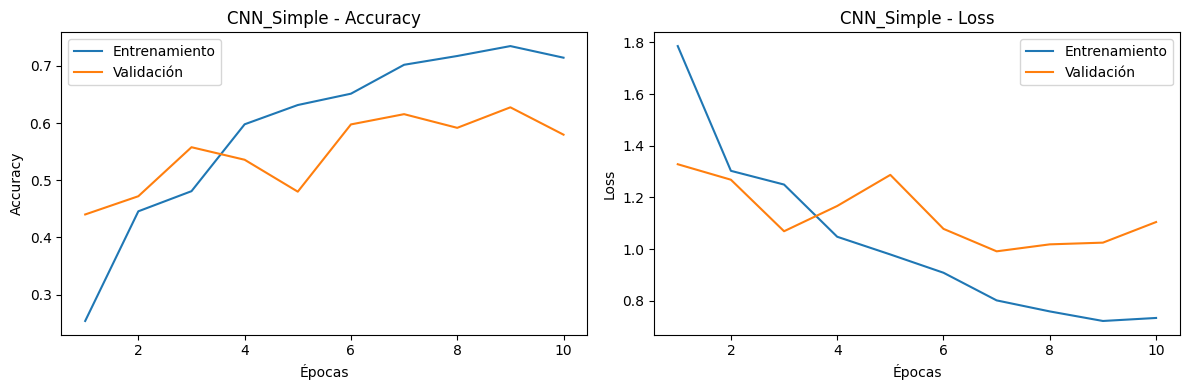

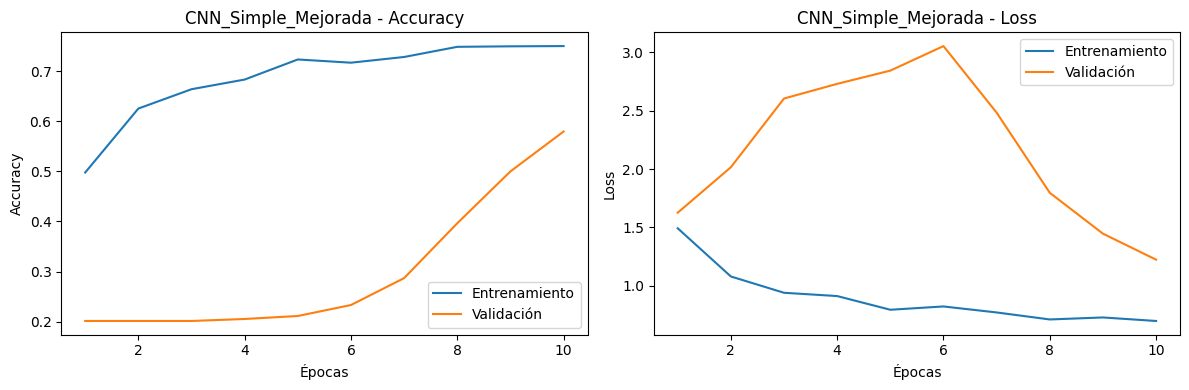

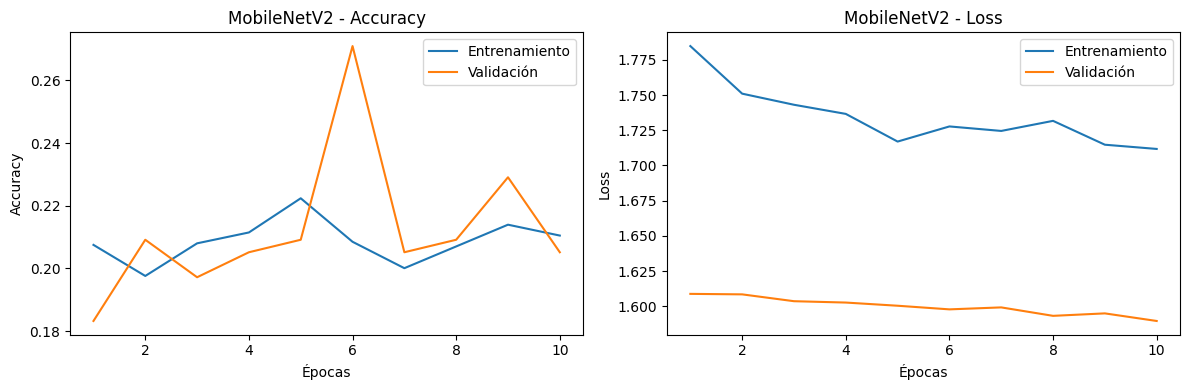

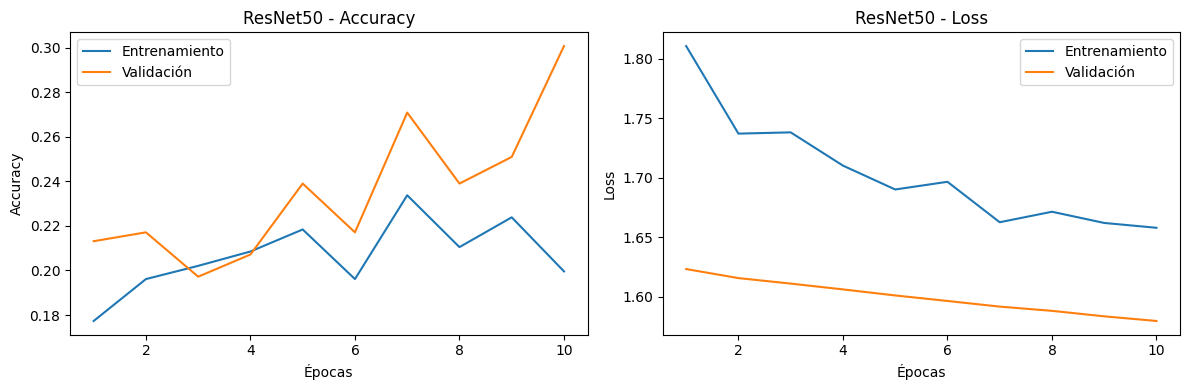

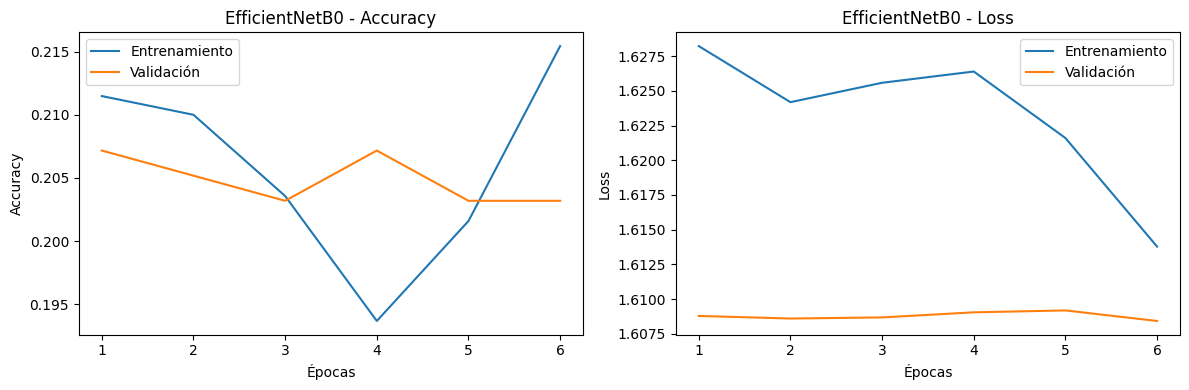

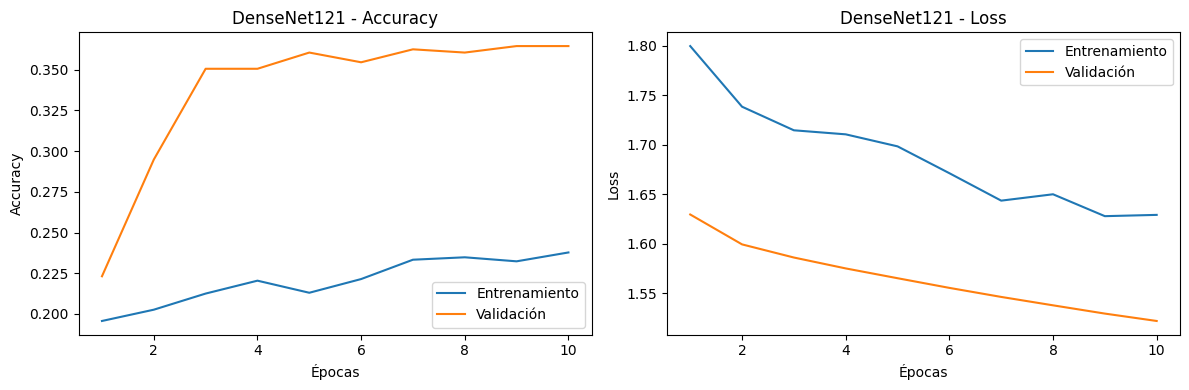

In [ ]:
# ============================================
# 9. Curvas ACC/Loss de todos los modelos
# ============================================

# Recorremos el diccionario de historias de entrenamiento
for model_name, history in histories_dict.items():
    # Graficamos las curvas de cada modelo
    plot_history(history, title_prefix=model_name)


PASO 10 **Comparación de métricas y selección del mejor modelo**

## 10. Comparación de métricas y selección del mejor modelo

En este paso:

- Convertimos la lista de resultados (`results_list`) en un DataFrame de pandas.
- Ordenamos los modelos por `Val_Accuracy` de mayor a menor.
- Imprimimos la tabla comparativa.
- Seleccionamos el modelo con mejor exactitud en validación.


In [ ]:
# ============================================
# 10. Tabla de métricas de modelos base
# ============================================

# Convertimos la lista de resultados en un DataFrame
metrics_df_base = pd.DataFrame(results_list).sort_values(
    by="Val_Accuracy", ascending=False
).reset_index(drop=True)
# Mostramos la tabla de métricas
metrics_df_base


,Modelo,Val_Accuracy,Val_Loss
0,CNN_Simple,0.627490,1.024675
1,CNN_Simple_Mejorada,0.579681,1.223360
2,DenseNet121,0.364542,1.529273
3,ResNet50,0.300797,1.579533
4,MobileNetV2,0.270916,1.597804
5,EfficientNetB0,0.207171,1.608788


In [ ]:
# ============================================
# 11. Comparación final: todos los modelos
# ============================================

metrics_df = pd.DataFrame(results_list).sort_values(
    by="Val_Accuracy", ascending=False
).reset_index(drop=True)

print("=== Tabla final de métricas (ordenada por Val_Accuracy) ===")
display(metrics_df)
# Tomamos la primera fila del DataFrame, que corresponde al mejor modelo
best_row = metrics_df.iloc[0]
best_model_name = best_row["Modelo"]
best_val_acc = best_row["Val_Accuracy"]
best_val_loss = best_row["Val_Loss"]

print("\n>>> MEJOR MODELO:", best_model_name)
print(f">>> Val_Accuracy: {best_val_acc:.4f}  |  Val_Loss: {best_val_loss:.4f}")
# Recuperamos el objeto Keras del mejor modelo
best_model = models_dict[best_model_name]


=== Tabla final de métricas (ordenada por Val_Accuracy) ===


,Modelo,Val_Accuracy,Val_Loss
0,CNN_Simple,0.627490,1.024675
1,CNN_Simple_Mejorada,0.579681,1.223360
2,DenseNet121,0.364542,1.529273
3,ResNet50,0.300797,1.579533
4,MobileNetV2,0.270916,1.597804
5,EfficientNetB0,0.207171,1.608788



>>> MEJOR MODELO: CNN_Simple
>>> Val_Accuracy: 0.6275  |  Val_Loss: 1.0247


PASO 11  **Matriz de confusión y reporte de clasificación**

## 11. Matriz de confusión y reporte de clasificación del mejor modelo

En este paso:

- Obtenemos las etiquetas reales (`y_true`) del generador de validación.
- Calculamos las predicciones del mejor modelo (`y_pred`).
- Generamos:
  - Un reporte de clasificación (precision, recall, f1-score).
  - Una matriz de confusión para ver qué clases se confunden entre sí.
- Esto es clave para interpretar la capacidad de **detección de enfermedades**.


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step
=== Reporte de clasificación (mejor modelo) ===
              precision    recall  f1-score   support

     Healthy       0.64      0.75      0.69       104
      Mosaic       0.43      0.50      0.46        92
      RedRot       0.73      0.51      0.60       103
        Rust       0.55      0.47      0.51       102
      Yellow       0.79      0.89      0.84       101

    accuracy                           0.63       502
   macro avg       0.63      0.63      0.62       502
weighted avg       0.63      0.63      0.62       502



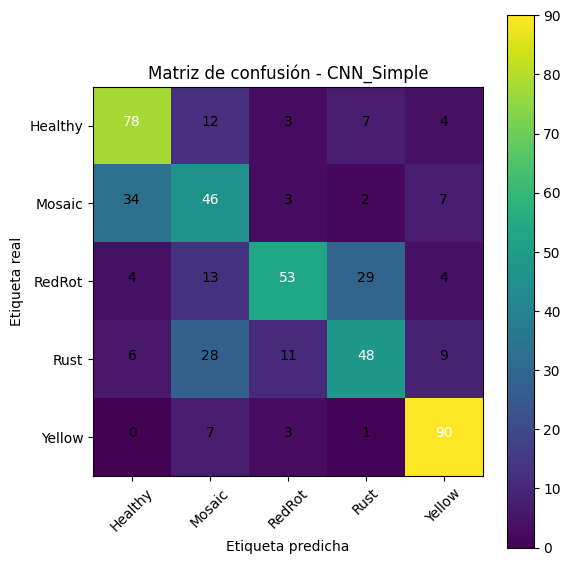

In [ ]:
# ============================================
# 11. Matriz de confusión y reporte del mejor modelo
# ============================================

# Reiniciamos el generador de validación para asegurar que recorra todo el conjunto desde el inicio
val_gen.reset()

# Etiquetas reales (clase correcta de cada imagen)
y_true = val_gen.classes

# Probabilidades predichas por el modelo para cada clase
y_prob = best_model.predict(val_gen)

# Etiquetas predichas: tomamos el índice de la clase con mayor probabilidad
y_pred = np.argmax(y_prob, axis=1)

# Mostramos el reporte de clasificación
print("=== Reporte de clasificación (mejor modelo) ===")
print(classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

# Calculamos la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Graficamos la matriz de confusión
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Matriz de confusión - {best_model_name}")
plt.colorbar()

# Definimos los nombres de las clases en los ejes
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, list(class_indices.keys()), rotation=45)
plt.yticks(tick_marks, list(class_indices.keys()))

# Agregamos los valores numéricos en cada celda de la matriz
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.tight_layout()
plt.show()


PASO 12 Guardar el mejor modelo en .h5

12. Guardar el mejor modelo en formato .h5
En esta celda:

Creamos la carpeta models si no existe.
Guardamos el mejor modelo encontrado en un archivo .h5.
Este archivo puede usarse luego para recargar el modelo en Keras o para despliegue.

In [ ]:
# ============================================
# 12. Guardar el mejor modelo en formato .h5
# ============================================

# Carpeta donde guardaremos los modelos
os.makedirs("models", exist_ok=True)

# Definimos la ruta del archivo .h5 usando el nombre del mejor modelo
h5_path = f"models/best_model_{best_model_name}.h5"

# Guardamos el modelo en formato HDF5
best_model.save(h5_path)

print("Mejor modelo guardado en:", h5_path)


Mejor modelo guardado en: models/best_model_CNN_Simple.h5


PASO 13  **Exportar el mejor modelo a ONNX**

## 13. Exportar el mejor modelo a formato ONNX

En este paso:

- Definimos la ruta del archivo `.onnx`.
- Utilizamos `tf2onnx` para convertir el modelo Keras a ONNX.
- ONNX permite usar el modelo en otros entornos (por ejemplo, APIs en otros lenguajes, motores de inferencia optimizados, etc.).
- Si ocurre un error (por ejemplo, no está instalada la librería), se muestra un mensaje de advertencia.


In [ ]:
# ============================================
# 13. Exportar el mejor modelo a formato ONNX
# ============================================

# Ruta donde se guardará el archivo ONNX
onnx_path = f"models/best_model_{best_model_name}.onnx"

try:
    # Definimos la especificación de entrada: lote de imágenes (None, alto, ancho, canales)
    spec = (tf.TensorSpec((None, IMG_SIZE[0], IMG_SIZE[1], 3), tf.float32, name="input"),)

    # Convertimos el modelo de Keras a formato ONNX
    model_proto, _ = tf2onnx.convert.from_keras(
        best_model,
        input_signature=spec,
        opset=13    # Versión de opset de ONNX
    )

    # Guardamos el modelo ONNX en disco
    with open(onnx_path, "wb") as f:
        f.write(model_proto.SerializeToString())

    print("Modelo ONNX guardado en:", onnx_path)

except Exception as e:
    # Si algo falla (por ejemplo, tf2onnx no está instalado), mostramos el error
    print("Error al exportar a ONNX:", e)
    print("Revisa que tf2onnx esté correctamente instalado si necesitas este formato.")


Error al exportar a ONNX: name 'tf2onnx' is not defined
Revisa que tf2onnx esté correctamente instalado si necesitas este formato.
